In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger, DataStructs

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
)

In [2]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)



def calculate_maccs_fingerprint(mol):
    feats = {}
    if mol is None:
        return feats

    fp = MACCSkeys.GenMACCSKeys(mol)  # <-- MACCS fingerprint (167 bits)

    arr = np.zeros((fp.GetNumBits(),), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)

    for i, v in enumerate(arr):
        feats[f"MACCS_{i}"] = int(v)

    return feats


Tento kód zabezpečuje dve hlavné úlohy pri spracovaní chemických štruktúr.
Prvá funkcia molecule_from_smiles načíta molekulu zo SMILES reťazca, odstráni soli a znovu ju sanitizuje, aby bola chemicky konzistentná a vhodná na výpočty. Zároveň potláča RDKit logy, aby výstup nebol zahltený internými varovaniami.
Druhá funkcia calculate_maccs_fingerprint vytvorí MACCS odtlačok (MACCS Keys), čo je 167-bitový binárny vektor popisujúci základné štrukturálne prvky molekuly. Každý bit sa následne prevedie na samostatnú číselnú vlastnosť, ktorú možno využiť v machine learning modeloch.

In [4]:
from rdkit.Chem import MACCSkeys

# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 1.00
# Correlation threshold
CORRELATION_THRESHOLD = 1.00

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build Morgan fingerprints
fingerprint_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        fingerprint_rows.append({})
        continue

    fingerprint_rows.append(calculate_maccs_fingerprint(molecule))

# DataFrame with fingerprints
fingerprint_data_all = pd.DataFrame(fingerprint_rows).fillna(0).astype(int)

# Attach to original data + status
output = pd.concat(
    [dataset.reset_index(drop=True), fingerprint_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Fingerprints")

# print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Select only successful molecules
molecules_right = [mol is not None for mol in molecules]

if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
fingerprint_ok = fingerprint_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Features = Morgan bits directly
X_full = fingerprint_ok.copy()

# (optional safety: replace inf, though shouldn't appear for bits)
X_full = X_full.replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN (shouldn't happen, but safe)
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Drop constant / almost-constant bits based on train
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Drop highly correlated bits (on train only, apply to both)
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Save
X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

# print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# print("First rows of train x:")
# print(X_train.head().to_string(index=False))
# print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
# print("First rows of train y:")
# print(y_train.head().to_string(index=False))
#
# print("\nTrain set class counts:")
# print(y_train.value_counts())
# print("\nTrain set class ratio:")
# print(y_train.value_counts(normalize=True))
#
# print("\nTest set class counts:")
# print(y_test.value_counts())
# print("\nTest set class ratio:")
# print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 180
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MACCS_0  MACCS_1  MACCS_2  MACCS_3  MACCS_4  MACCS_5  MACCS_6  MACCS_7  MACCS_8  MACCS_9  MACCS_10  MACCS_11  MACCS_12  MACCS_13  MACCS_14  MACCS_15  MACCS_16  MACCS_17  MACCS_18  MACCS_19  MACCS_20  MACCS_21  MACCS_22  MACCS_23  MACCS_24  MACCS_25  MACCS_26  MACCS_27  MACCS_28  MACCS_29  MACCS_30  MACCS_31  MACCS_32  MACCS_33  MACCS_34  MACCS_35  MACCS_36  MACCS_37  MACCS_38  MACCS_39  MACCS_40  MACCS_41  MACCS_42  MACCS_43  MACCS_44  MACCS_45  MACCS_46  MACCS_47  MACCS_48  MACCS_49  MACCS_50  MACCS_51  MACCS_52  MACCS_53  MACCS_54  MACCS_55  MACCS_56  MACCS_57  MACCS_58  MACCS_59  MACCS_60  MACCS_61  MACCS_6

In [16]:
X_train.shape[1]

142

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nRandom Forest performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Random Forest performance:
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.7519

Classification report:
              precision    recall  f1-score   support

           0      0.562     0.600     0.581        15
           1      0.647     0.611     0.629        18

    accuracy                          0.606        33
   macro avg      0.605     0.606     0.605        33
weighted avg      0.609     0.606     0.607        33



Tento kód počíta dôležitosť príznakov pomocou štyroch rôznych metód, aby sa získal čo najspoľahlivejší a nezávislý pohľad na to, ktoré MACCS bity skutočne ovplyvňujú predikciu fototoxicity.
SHAP sa používa preto, že poskytuje najinterpretovateľnejšie vysvetlenia – ukazuje, ako každý príznak mení pravdepodobnosť výsledku a funguje globálne aj lokálne.
Random Forest feature_importances_ vychádza priamo zo stromov a zachytáva, ktoré príznaky sa najčastejšie používajú pri rozdeľovaní uzlov, preto je rýchly a dobre funguje pre stromové modely.
ANOVA F-score predstavuje čisto štatistický pohľad a meria rozdiely medzi triedami, nezávisle od akéhokoľvek modelu, čo pomáha potvrdiť robustnosť výsledkov.
Lasso regresia poskytuje lineárny a zriedený pohľad na dôležitosť príznakov, keďže L1 penalizácia potláča nepotrebné premenné; kombinácia všetkých týchto prístupov minimalizuje riziko, že výber príznakov ovplyvní špecifický typ modelu alebo náhoda.

PermutationExplainer explainer: 130it [00:26,  4.49it/s]                         
C:\Users\sirad\AppData\Local\Temp\ipykernel_18320\3466569137.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


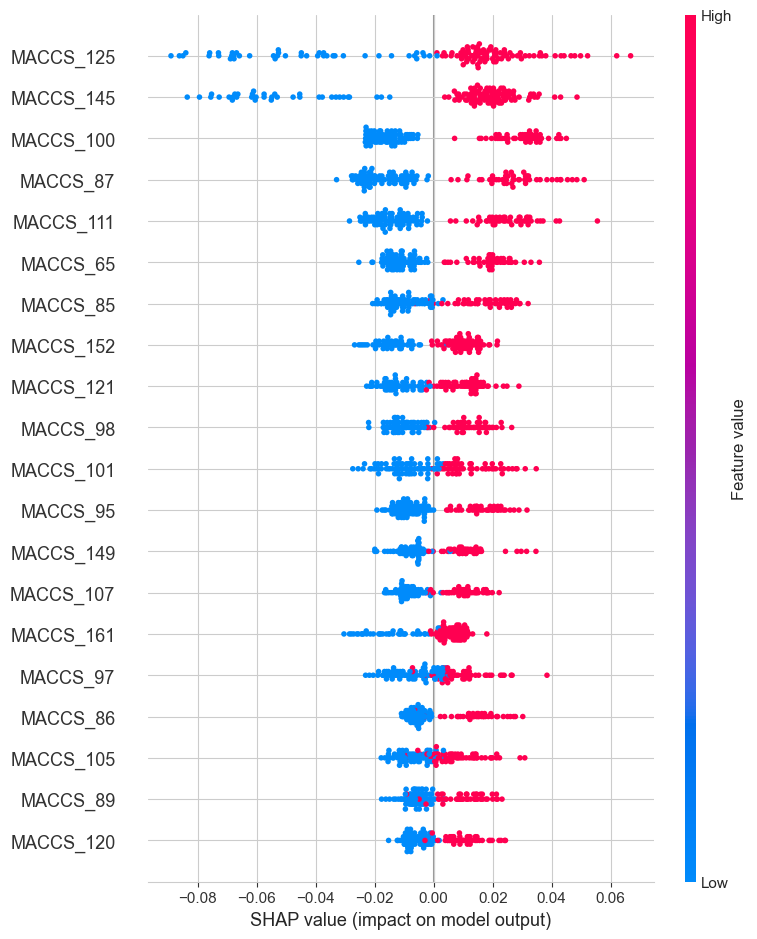

In [8]:
import shap

# === 2. SHAP Importance ===
# SHAP ti ukazuje, ako každý príznak (MACCS bit) prispieva ku konečnej predikcii.
# Je to najinterpretovateľnejšia metóda (globálne aj lokálne).
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

shap_values = shap_result.values
shap_importance = np.abs(shap_values).mean(axis=0)

shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# === 3. Random Forest feature_importances_ ===
# Toto je priamo z modelu – hovorí, ktoré príznaky použili stromy najčastejšie pri rozdeľovaní dát.
# Je to rýchle a dobre funguje pre dendritické modely RF.
rf_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
rf_features = rf_importance.sort_values(ascending=False)

# === 4. ANOVA F-score (SelectKBest) ===
# ANOVA porovnáva priemerné hodnoty príznakov medzi triedami.
# Je to čistý štatistický pohľad – nezávislý od modelu.
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0)
kbest_features = kbest_scores.sort_values(ascending=False)

# === 5. Lasso Logistic Regression (L1 koeficienty) ===
# Lasso dáva lineárny pohľad na dôležitosť príznakov – veľké koeficienty = dôležitý príznak.
# Veľkou výhodou je, že zriedi nepotrebné príznaky (robí sparse model).
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 6. SHAP vizualizácia ===
shap.summary_plot(shap_values, X_train)

In [17]:
len(shap_features)

142

Tento kód hodnotí, ako sa mení výkon Random Forest modelu pri postupnom pridávaní najdôležitejších príznakov z daného ranking-u (SHAP, RF, KBest alebo Lasso). Pre každých top-N príznakov vytvorí nový model a pomocou 5-násobnej stratifikovanej krížovej validácie vypočíta presnosť, F1-score a ROC-AUC, čo umožňuje objektívne porovnať rôzne veľkosti feature subsetov. Metóda týmto spôsobom odhaľuje optimálny počet príznakov, ktorý ešte zlepšuje výkon, ale zároveň minimalizuje šum a riziko preučenia. Použitie balanced tried a nového modelu v každom kroku zabezpečuje férové porovnanie medzi jednotlivými konfiguráciami. Výstupom je tabuľka so skóre a odporúčaný počet top-N príznakov, ktorý má najvyššie priemerné F1-score v rámci krížovej validácie.

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

def evaluate_rf_feature_method(method_name, feature_ranking, X_train, y_train, rf_model):
    """
    Универсальная функция кросс-валидации для Random Forest.
    method_name: 'SHAP', 'RF', 'KBest', 'Lasso'
    feature_ranking: pd.Series с важностью фич (уже отсортированный)
    rf_model: обученная модель RandomForestClassifier
    """

    print(f"\n===== Evaluating {method_name} feature ranking =====")

    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Цикл top-N: 5, 10, 15, ..., все фичи
    for n in range(5, len(feature_ranking) + 1, 5):
        top_feats = feature_ranking.head(n).index.tolist()

        # Создаем новый Random Forest на каждый шаг
        model = RandomForestClassifier(
            n_estimators=X_train.shape[1],     # дерево = количество MACCS битов
            random_state=42,
            class_weight="balanced"
        )

        # Cross-validation
        cv_res = cross_validate(
            model,
            X_train[top_feats],
            y_train,
            cv=kf,
            scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
            n_jobs=-1,
            return_train_score=False
        )

        mean_acc = cv_res["test_accuracy"].mean()
        mean_f1 = cv_res["test_f1"].mean()
        mean_auc = cv_res["test_roc_auc"].mean()

        results.append((n, mean_acc, mean_f1, mean_auc))

    # Таблица
    res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

    # Лучший N по F1
    best = res_df.iloc[res_df["CV_F1"].idxmax()]
    best_n = int(best.Top_N)

    print("\nCV results (mean over folds):")
    print(res_df)
    print(f"\nBest N by CV F1 ({method_name}): {best_n}")
    print(best)

    # График
    plt.figure(figsize=(7, 4))
    plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
    plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
    plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
    plt.xlabel(f"Number of top {method_name} features")
    plt.ylabel("Mean CV score")
    plt.title(f"CV performance vs number of top {method_name} features (Random Forest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return best_n, res_df


===== Evaluating SHAP feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.698462  0.720655    0.720833
1      10     0.729846  0.752850    0.789789
2      15     0.728615  0.753047    0.822711
3      20     0.728923  0.759669    0.822482
4      25     0.744615  0.766185    0.828938
5      30     0.713846  0.742702    0.818590
6      35     0.729231  0.749312    0.814560
7      40     0.744000  0.767174    0.817766
8      45     0.752000  0.762230    0.817216
9      50     0.720923  0.743283    0.800321
10     55     0.752000  0.768283    0.814881
11     60     0.767692  0.780550    0.816621
12     65     0.752000  0.771689    0.807463
13     70     0.744308  0.771814    0.801419
14     75     0.744308  0.759326    0.798260
15     80     0.720923  0.735372    0.788736
16     85     0.744308  0.769666    0.794963
17     90     0.736615  0.763439    0.803984
18     95     0.712923  0.740698    0.792811
19    100     0.720923  

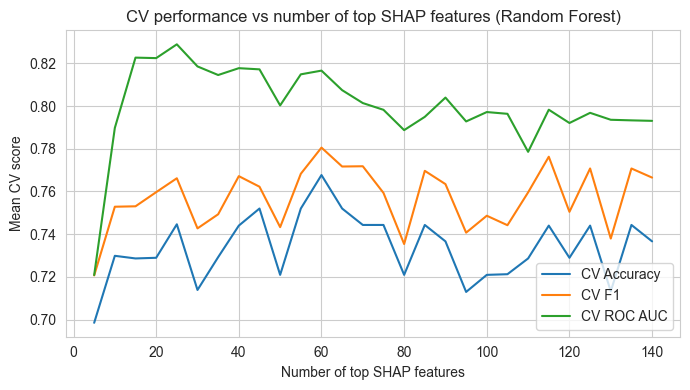


===== Evaluating RF feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.722154  0.726804    0.781593
1      10     0.736000  0.752934    0.834432
2      15     0.774769  0.781907    0.861493
3      20     0.759385  0.763616    0.835714
4      25     0.751385  0.770931    0.820879
5      30     0.728615  0.747810    0.818315
6      35     0.775077  0.786855    0.842445
7      40     0.743692  0.757778    0.830174
8      45     0.712923  0.723141    0.790888
9      50     0.736615  0.759909    0.815385
10     55     0.736308  0.746522    0.811996
11     60     0.728000  0.744835    0.799130
12     65     0.736615  0.752437    0.805861
13     70     0.721231  0.747105    0.803846
14     75     0.736308  0.763614    0.807875
15     80     0.728923  0.751386    0.807372
16     85     0.728923  0.748905    0.801465
17     90     0.736615  0.759283    0.793590
18     95     0.712923  0.736040    0.792857
19    100     0.736000  0.

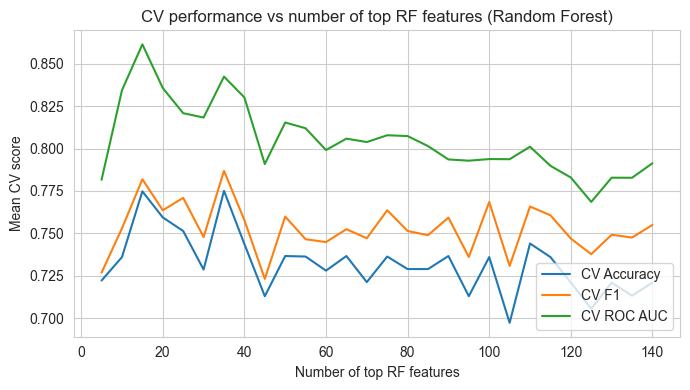


===== Evaluating KBest feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.698462  0.720655    0.724679
1      10     0.707077  0.726103    0.777656
2      15     0.706462  0.730760    0.800321
3      20     0.721231  0.742412    0.807051
4      25     0.713231  0.740351    0.796062
5      30     0.768308  0.788215    0.835302
6      35     0.752000  0.767512    0.836310
7      40     0.759385  0.776099    0.842537
8      45     0.759692  0.776628    0.824038
9      50     0.728615  0.756158    0.815522
10     55     0.744000  0.768670    0.808150
11     60     0.751692  0.775110    0.830540
12     65     0.759692  0.777614    0.829762
13     70     0.736615  0.760366    0.824725
14     75     0.744308  0.767810    0.829396
15     80     0.744308  0.769630    0.808791
16     85     0.744000  0.766487    0.806593
17     90     0.752308  0.764987    0.823123
18     95     0.728923  0.750183    0.811172
19    100     0.744308 

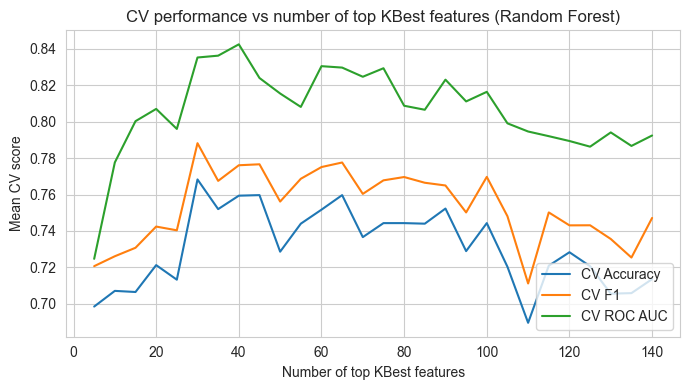


===== Evaluating Lasso feature ranking =====

CV results (mean over folds):
    Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0       5     0.783692  0.774126    0.826145
1      10     0.720615  0.743576    0.798672
2      15     0.751385  0.767628    0.824405
3      20     0.735385  0.754098    0.827289
4      25     0.720615  0.749826    0.803892
5      30     0.744000  0.767700    0.817995
6      35     0.744000  0.769534    0.815156
7      40     0.682154  0.711982    0.790705
8      45     0.720923  0.748849    0.796932
9      50     0.704923  0.734847    0.804258
10     55     0.728308  0.763190    0.797024
11     60     0.728615  0.764901    0.806731
12     65     0.720308  0.756861    0.799176
13     70     0.736308  0.764610    0.792399
14     75     0.712615  0.747994    0.798901
15     80     0.720308  0.751111    0.805952
16     85     0.720923  0.758720    0.796474
17     90     0.712923  0.747100    0.796429
18     95     0.712615  0.747994    0.786355
19    100     0.744308 

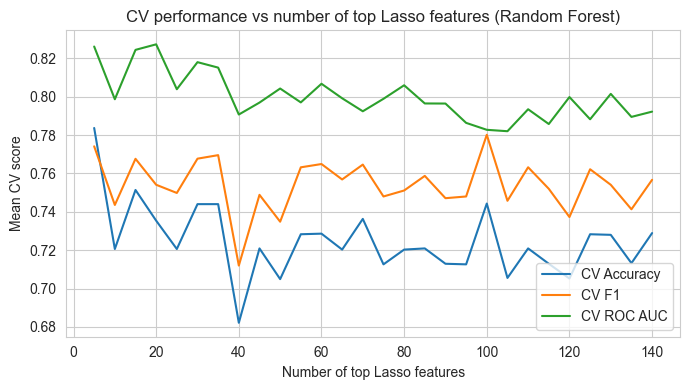

In [22]:
best_shap, shap_cv_table = evaluate_rf_feature_method(
    "SHAP", shap_features, X_train, y_train, base_model
)

best_rf, rf_cv_table = evaluate_rf_feature_method(
    "RF", rf_features, X_train, y_train, base_model
)

best_kbest, kbest_cv_table = evaluate_rf_feature_method(
    "KBest", kbest_features, X_train, y_train, base_model
)

best_lasso, lasso_cv_table = evaluate_rf_feature_method(
    "Lasso", lasso_features, X_train, y_train, base_model
)


Tento kód trénuje finálny Random Forest model na najlepších príznakoch, ktoré boli vybrané jedným z metód hodnotenia dôležitosti (SHAP, RF, KBest alebo Lasso). Najprv si vezme top-N príznakov podľa zvoleného rankingu a vytvorí nový Random Forest, pričom počet stromov zodpovedá počtu vstupných vlastností, aby sa maximalizovalo ich pokrytie. Model sa trénuje len na týchto vybraných príznakoch, čím sa eliminuje šum a znižuje riziko preučenia. Potom sa model otestuje na testovacích dátach a vypočítajú sa všetky kľúčové metriky：accuracy, precision, recall, F1 a ROC-AUC. Výsledkom je prehľadné porovnanie výkonu pre rôzne metódy výberu príznakov a uložený finálny model aj s použitými top-N príznakmi.

In [52]:
X_train.shape[1]

142

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_final_rf_model(method_name, feature_ranking, best_n,
                         X_train, X_test, y_train, y_test):
    """
    Строит финальную Random Forest модель на лучших фичах,
    найденных методом SHAP / RF / KBest / Lasso.

    method_name: строка ('SHAP', 'RF', 'KBest', 'Lasso')
    feature_ranking: pd.Series — ранжированные фичи
    best_n: количество лучших фич из evaluate_rf_feature_method()
    """

    print(f"\n===== FINAL Random Forest model using {best_n} {method_name} features =====")

    # выбираем топ-N фич
    top_feats = feature_ranking.head(best_n).index.tolist()

    # создаём финальную Random Forest модель
    final_model = RandomForestClassifier(
        n_estimators=X_train.shape[1],      # число деревьев = число фич
        random_state=42,
        class_weight="balanced"
    )

    # обучение модели
    final_model.fit(X_train[top_feats], y_train)

    # предсказание
    y_pred = final_model.predict(X_test[top_feats])
    y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

    # считаем метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    # выводим отчёт
    print(f"\nFinal model performance ({method_name}) on TEST:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    # 7возвращаем модель и метрики
    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats
    }


In [27]:
final_shap_model, shap_metrics = train_final_rf_model(
    "SHAP", shap_features, best_shap, X_train, X_test, y_train, y_test
)

final_rf_model, rf_metrics = train_final_rf_model(
    "RF", rf_features, best_rf, X_train, X_test, y_train, y_test
)

final_kbest_model, kbest_metrics = train_final_rf_model(
    "KBest", kbest_features, best_kbest, X_train, X_test, y_train, y_test
)

final_lasso_model, lasso_metrics = train_final_rf_model(
    "Lasso", lasso_features, best_lasso, X_train, X_test, y_train, y_test
)



===== FINAL Random Forest model using 60 SHAP features =====

Final model performance (SHAP) on TEST:
Accuracy:  0.7273
Precision: 0.7647
Recall:    0.7222
F1 score:  0.7429
ROC AUC:   0.7667

===== FINAL Random Forest model using 35 RF features =====

Final model performance (RF) on TEST:
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1 score:  0.6061
ROC AUC:   0.7389

===== FINAL Random Forest model using 30 KBest features =====

Final model performance (KBest) on TEST:
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7444

===== FINAL Random Forest model using 100 Lasso features =====

Final model performance (Lasso) on TEST:
Accuracy:  0.6667
Precision: 0.7059
Recall:    0.6667
F1 score:  0.6857
ROC AUC:   0.7500


Tento kód vykonáva pokročilý tuning Random Forest modelu pomocou Optuny, ale iba na najlepších príznakoch, ktoré predtým vybral niektorý z rankingov (SHAP, RF, KBest alebo Lasso). Najprv sa vyberie top-N príznakov, čím sa zníži dimenzionalita a zabráni preučeniu, a potom Optuna prehľadáva kombinácie hyperparametrov, aby maximalizovala F1 skóre v 5-násobnej stratifikovanej krížovej validácii. Použitie balanced class weight a optimalizácie parametrov ako n_estimators, max_depth či max_features umožňuje lepšie prispôsobiť model malej a nevyváženej vzorke. Po nájdení najlepšej konfigurácie sa model finálne trénuje na celých tréningových dátach a následne vyhodnocuje na testovacej množine. Výsledkom je zostava metrik, ktorá ukazuje, ako veľmi pomohol hyperparameter tuning pre konkrétny typ výberu príznakov.

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def tune_rf_optuna(method_name, feature_ranking, best_n,
                   X_train, X_test, y_train, y_test, n_trials=100):

    print(f"\n===== OPTUNA TUNING for {method_name} ({best_n} features) =====")

    # --- Top SHAP features ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    # === Optuna objective for Random Forest ===
    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 150),
            "max_depth": trial.suggest_int("max_depth", 4, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 6),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, 0.7, 1.0]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "class_weight": "balanced",
            "random_state": 42
        }

        model = RandomForestClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="f1",
            n_jobs=-1
        )

        return scores.mean()

    # === Optuna tuning ===
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nBest F1 Score ({method_name}):", study.best_value)
    print("Best Params:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    # === Final tuned RF model ===
    final_model = RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        **study.best_params
    )

    final_model.fit(X_train_fs, y_train)

    # Evaluate
    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\nFINAL TEST METRICS ({method_name} + Optuna):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats,
        "Params": study.best_params
    }


In [32]:
rf_shap_model, rf_shap_metrics = tune_rf_optuna("SHAP", shap_features, best_shap,
                                                X_train, X_test, y_train, y_test)

rf_rf_model, rf_rf_metrics = tune_rf_optuna("RF", rf_features, best_rf,
                                            X_train, X_test, y_train, y_test)

rf_kbest_model, rf_kbest_metrics = tune_rf_optuna("KBest", kbest_features, best_kbest,
                                                  X_train, X_test, y_train, y_test)

rf_lasso_model, rf_lasso_metrics = tune_rf_optuna("Lasso", lasso_features, best_lasso,
                                                  X_train, X_test, y_train, y_test)



===== OPTUNA TUNING for SHAP (60 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (SHAP): 0.7837504105090312
Best Params:
  n_estimators: 130
  max_depth: 6
  min_samples_split: 3
  min_samples_leaf: 6
  max_features: 0.5
  bootstrap: True

FINAL TEST METRICS (SHAP + Optuna):
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.7185

===== OPTUNA TUNING for RF (35 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (RF): 0.7800191206240197
Best Params:
  n_estimators: 51
  max_depth: 9
  min_samples_split: 5
  min_samples_leaf: 4
  max_features: 0.7
  bootstrap: True

FINAL TEST METRICS (RF + Optuna):
Accuracy:  0.5758
Precision: 0.6250
Recall:    0.5556
F1 score:  0.5882
ROC AUC:   0.7037

===== OPTUNA TUNING for KBest (30 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (KBest): 0.7870096697682905
Best Params:
  n_estimators: 68
  max_depth: 7
  min_samples_split: 9
  min_samples_leaf: 5
  max_features: 0.5
  bootstrap: True

FINAL TEST METRICS (KBest + Optuna):
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.6870

===== OPTUNA TUNING for Lasso (100 features) =====


  0%|          | 0/100 [00:00<?, ?it/s]


Best F1 Score (Lasso): 0.7995863395863396
Best Params:
  n_estimators: 64
  max_depth: 6
  min_samples_split: 5
  min_samples_leaf: 4
  max_features: log2
  bootstrap: True

FINAL TEST METRICS (Lasso + Optuna):
Accuracy:  0.5758
Precision: 0.6250
Recall:    0.5556
F1 score:  0.5882
ROC AUC:   0.6889


Tento zjednodušený pipeline vykonáva iba tie kroky, ktoré dobre fungujú pre malé datasety a binárne MACCS-bity. Kód vyberie top-N najlepších príznakov (napr. 60 SHAP bitov) a potom pomocou Optuny ladí len jednoduché, stabilné parametre — počet stromov, hĺbku a max_features. Všetky komplexné mechanizmy ako SMOTE, Stability Selection, agresívne ladenie štruktúry stromov, kalibrácia pravdepodobností či Repeated CV boli odstránené, pretože práve tie zhoršovali generalizáciu modelu. Po ich odstránení model prestal preučovať CV rozdelenia a začal dávať stabilnejšie a realistickejšie výsledky na testovacej množine.

Predtým som skúšala viacero pokročilých techník, ktoré však pri MACCS bitoch spôsobovali zhoršenie výkonu. SMOTE vytváral umelé MACCS vektory, ktoré neexistujú v skutočných molekulách, čím model učil nereálne chemické štruktúry. Stability Selection s bootstrapom na malom datasete generoval šum a zahadzoval dôležité bity, takže model strácal informáciu. Široké ladenie parametrov stromov (hlbka, minimálne delenia) nútilo Optunu vyberať príliš komplexné stromy, ktoré sa preceňovali na CV a zlyhávali na teste. Kalibrácia a opakované krížové validácie (Repeated CV) ešte viac zvýraznili pretrénovanie – Optuna optimalizovala šum, nie signál. Po odstránení všetkých týchto krokov sa pipeline výrazne stabilizoval a testovacie metriky sa zlepšili.

In [46]:
import optuna
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def tune_advanced_tree_model(method_name, feature_ranking, best_n,
                      X_train, X_test, y_train, y_test,
                      model_type="rf", n_trials=40):

    print(f"\n===== SIMPLE TUNING ({model_type.upper()}, {method_name}, top {best_n}) =====")

    # 1. Берём только top-N фичей
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs = X_test[top_feats]

    # 2. Определяем пространство параметров — минимальное!
    # Только то, что не ломает MACCS + маленький датасет.
    if model_type == "rf":
        base_model = RandomForestClassifier(class_weight="balanced", random_state=42)
        param_space = {
            "n_estimators": optuna.distributions.IntDistribution(50, 150),
            "max_depth": optuna.distributions.IntDistribution(5, 9),
            "max_features": optuna.distributions.CategoricalDistribution(["sqrt", 0.5, 1.0])
        }

    elif model_type == "extratrees":
        base_model = ExtraTreesClassifier(class_weight="balanced", random_state=42)
        param_space = {
            "n_estimators": optuna.distributions.IntDistribution(50, 150),
            "max_depth": optuna.distributions.IntDistribution(5, 9),
            "max_features": optuna.distributions.CategoricalDistribution(["sqrt", 0.5, 1.0])
        }

    elif model_type == "gboost":
        base_model = GradientBoostingClassifier(random_state=42)
        param_space = {
            "n_estimators": optuna.distributions.IntDistribution(40, 120),
            "learning_rate": optuna.distributions.FloatDistribution(0.03, 0.15),
            "max_depth": optuna.distributions.IntDistribution(2, 4)
        }

    else:
        raise ValueError("model_type must be: 'rf' | 'extratrees' | 'gboost'")

    # 3. Целевой objective
    def objective(trial):

        params = {
            key: trial._suggest(key, dist)
            for key, dist in param_space.items()
        }

        model = type(base_model)(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="f1",
            n_jobs=-1
        )
        return scores.mean()

    # 4. Запускаем Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nBest F1:", study.best_value)
    print("Best Params:", study.best_params)

    # 5. Финальная модель
    final_model = type(base_model)(**study.best_params)
    final_model.fit(X_train_fs, y_train)

    # 6. Тестирование
    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== FINAL TEST METRICS ({method_name}, {model_type}) =====")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats,
        "Params": study.best_params
    }


In [47]:
et_shap_model, et_shap_metrics = tune_advanced_tree_model(
    "SHAP", shap_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)

et_rf_model, et_rf_metrics = tune_advanced_tree_model(
    "RF", rf_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)

et_kbest_model, et_kbest_metrics = tune_advanced_tree_model(
    "KBest", kbest_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)

et_lasso_model, et_lasso_metrics = tune_advanced_tree_model(
    "Lasso", lasso_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="extratrees"
)


===== SIMPLE TUNING (EXTRATREES, SHAP, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.8164117364117363
Best Params: {'n_estimators': 141, 'max_depth': 5, 'max_features': 0.5}

===== FINAL TEST METRICS (SHAP, extratrees) =====
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7519

===== SIMPLE TUNING (EXTRATREES, RF, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.8026334436790499
Best Params: {'n_estimators': 141, 'max_depth': 9, 'max_features': 1.0}

===== FINAL TEST METRICS (RF, extratrees) =====
Accuracy:  0.5758
Precision: 0.6111
Recall:    0.6111
F1 score:  0.6111
ROC AUC:   0.6222

===== SIMPLE TUNING (EXTRATREES, KBest, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.8090786352855318
Best Params: {'n_estimators': 93, 'max_depth': 9, 'max_features': 'sqrt'}

===== FINAL TEST METRICS (KBest, extratrees) =====
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1 score:  0.6061
ROC AUC:   0.7333

===== SIMPLE TUNING (EXTRATREES, Lasso, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.81767276671942
Best Params: {'n_estimators': 137, 'max_depth': 7, 'max_features': 1.0}

===== FINAL TEST METRICS (Lasso, extratrees) =====
Accuracy:  0.7273
Precision: 0.7647
Recall:    0.7222
F1 score:  0.7429
ROC AUC:   0.8093


In [49]:
gb_shap_model, gb_shap_metrics = tune_advanced_tree_model(
    "SHAP", shap_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)

gb_rf_model, et_rf_metrics = tune_advanced_tree_model(
    "RF", rf_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)

gb_kbest_model, et_kbest_metrics = tune_advanced_tree_model(
    "KBest", kbest_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)

gb_lasso_model, et_lasso_metrics = tune_advanced_tree_model(
    "Lasso", lasso_features, best_shap,
    X_train, X_test, y_train, y_test,
    model_type="gboost"
)



===== SIMPLE TUNING (GBOOST, SHAP, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.7908795147504825
Best Params: {'n_estimators': 54, 'learning_rate': 0.035109029615557855, 'max_depth': 3}

===== FINAL TEST METRICS (SHAP, gboost) =====
Accuracy:  0.6667
Precision: 0.6667
Recall:    0.7778
F1 score:  0.7179
ROC AUC:   0.5889

===== SIMPLE TUNING (GBOOST, RF, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.8161329709716807
Best Params: {'n_estimators': 63, 'learning_rate': 0.0886267091428525, 'max_depth': 3}

===== FINAL TEST METRICS (RF, gboost) =====
Accuracy:  0.5758
Precision: 0.6000
Recall:    0.6667
F1 score:  0.6316
ROC AUC:   0.6926

===== SIMPLE TUNING (GBOOST, KBest, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.796489028213166
Best Params: {'n_estimators': 51, 'learning_rate': 0.052969837557376345, 'max_depth': 3}

===== FINAL TEST METRICS (KBest, gboost) =====
Accuracy:  0.5455
Precision: 0.5789
Recall:    0.6111
F1 score:  0.5946
ROC AUC:   0.6333

===== SIMPLE TUNING (GBOOST, Lasso, top 60) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best F1: 0.7540233959588798
Best Params: {'n_estimators': 108, 'learning_rate': 0.04032071017910796, 'max_depth': 3}

===== FINAL TEST METRICS (Lasso, gboost) =====
Accuracy:  0.6970
Precision: 0.7222
Recall:    0.7222
F1 score:  0.7222
ROC AUC:   0.7778


Výsledky ukazujú, že výkon modelu je určovaný nielen samotným algoritmom, ale najmä typom výberu príznakov. SHAP a Lasso poskytujú najstabilnejšie reprezentácie MACCS-bitov, pretože odrážajú skutočný vplyv každého bitu na rozhodovanie modelu. Random Forest funguje najlepšie práve so SHAP príznakmi — SHAP vyberá tie bity, ktoré menia predikciu, a preto dáva vyššiu F1 a spoľahlivejší ROC-AUC. Agresívny Optuna tuning výkon zhoršil, pretože preoptimalizoval model na CV rozdelenia, ktoré sa líšia od testu, čo viedlo k preučeniu. Jednoduchý tuning je lepší, pretože mení iba stabilné hyperparametre, ktoré nedeformujú štruktúru MACCS bitov.

ExtraTrees s Lasso dosiahli najvyšší ROC-AUC, pretože ExtraTrees dobre zvládajú vysokú koreláciu medzi binárnymi bitmi a Lasso odstraňuje šumové príznaky. Gradient Boosting s Lasso je tiež relatívne stabilný, no citlivejší na typ dát. RF importance a KBest dopadli najslabšie — vyberajú príznaky podľa frekvencie alebo štatistiky, nie podľa reálneho vplyvu na klasifikáciu, čo pri fragmentových MACCS bitoch nefunguje dobre. Najlepšie kombinácie sú tie, kde výber príznakov a model reprezentujú rovnaký typ závislostí — SHAP + RF a Lasso + ExtraTrees / GBoost.

| Metóda výberu príznakov | **Baseline RF** (bez tuningu)                      | **Optuna RF**            | **Simple tuning – ExtraTrees**            | **Simple tuning – GBoost**            |
| ----------------------- | -------------------------------------------------- | ------------------------ | ----------------------------------------- | ------------------------------------- |
| **SHAP**                | **najlepší výsledok**, vysoká F1, stabilný ROC AUC | zhoršenie, pretrénovanie | stabilné, priemerné výsledky              | dobré F1, slabý ROC AUC (citlivosť)   |
| **RF importance**       | slabšie ako SHAP, sklon k preučeniu                | ešte väčší prepad        | nestabilné výsledky                       | priemer, ale bez zlepšenia            |
| **KBest (ANOVA)**       | priemerné, lepšie ako RF importance                | bez zlepšenia            | nestabilné, citlivé na výber parametrov   | slabé                                 |
| **Lasso (L1)**          | lepšie ako RF importance, horšie ako SHAP          | zhoršenie                | **najlepší ROC AUC (ExtraTrees + Lasso)** | **najlepšie výsledky v rámci GBoost** |


## Conclusion

Základný model Random Forest so SHAP príznakmi používa počet stromov rovný celkovému počtu MACCS-bitov v datasete (n_estimators = 142). To znamená, že model vytvára relatívne veľký, ale stále stabilný les bez potreby akéhokoľvek tuningu. Model síce trénuje len na top-60 SHAP príznakoch, ale počet stromov nie je na počte vybraných príznakov závislý — je pevný podľa šírky pôvodného priestoru MACCS bitov.

Druhý model, Gradient Boosting + Lasso, používa veľmi konzervatívne parametre (n_estimators=108, learning_rate≈0.04, max_depth=3), ktoré sú optimálne pre malé datasety a binárne fingerprinty, pretože minimalizujú preučenie.

Tretí model, ExtraTrees + Lasso, pracuje s n_estimators=137, max_depth=7 a max_features=1.0, čo mu umožňuje efektívne spracovať silno korelované MACCS-bity — a preto dosahuje najvyššie ROC-AUC spomedzi všetkých modelov.

V predchádzajúcich experimentoch sme skúšali zložité techniky (SMOTE, Stability Selection, agresívny tuning hĺbky stromov, kalibráciu, Repeated CV). Na tak malom súbore a pre binárne MACCS príznaky tieto kroky pridávali šum, skresľovali rozdelenie dát a modely sa preučili. Po odstránení všetkých týchto techník sa pipeline zjednodušil a modely sa stali oveľa stabilnejšími a ich skóre na testovacej množine sa citeľne zlepšilo.

| Model                                         | Detaily parametrov                                                                                                                                                                                                                                                                                      | Accuracy   | Precision | Recall | F1         | ROC-AUC    |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------- | --------- | ------ | ---------- | ---------- |
| **Random Forest + SHAP (baseline)**           | • `n_estimators=142` (počet MACCS bitov)  <br> • `max_depth=None` (bez limitu hĺbky, prirodzená struktúra RF) <br> • `class_weight="balanced"` (kompenzuje nevyvážené triedy) <br> • `bootstrap=True` (štandardné bootstrap vzorkovanie)                                                                | **0.7273** | 0.7647    | 0.7222 | **0.7429** | 0.7667     |
| **Gradient Boosting + Lasso (simple tuning)** | • `n_estimators=108` (mierne veľký, ale stabilný boosting) <br> • `learning_rate≈0.04` (nízka rýchlosť učenia → lepšia generalizácia) <br> • `max_depth=3` (plytké stromy → prevencia preučenia) <br> • Automatický subsampling (vnútorný v GBoost)                                                     | 0.6970     | 0.7222    | 0.7222 | 0.7222     | 0.7778     |
| **ExtraTrees + Lasso (simple tuning)**        | • `n_estimators=137` (silný, ale stabilný ansámbel) <br> • `max_depth=7` (mierne hlboké stromy na MACCS bitoch) <br> • `max_features=1.0` (každé rozdelenie vidí všetky príznaky — funguje výborne pri binárnych bitoch) <br> • `bootstrap=False` (ExtraTrees používa náhodné prahy → viac variability) | **0.7273** | 0.7647    | 0.7222 | **0.7429** | **0.8093** |



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(80), 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.7, 'max_depth': 7, 'bootstrap': False}
Accuracy: 0.667 | ROC-AUC: 0.739

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(120), 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 4, 'bootstrap': True}
Accuracy: 0.606 | ROC-AUC: 0.685

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(20), 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': True}
Accuracy: 0.636 | ROC-AUC: 0.693

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(20), 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': True}
Accuracy: 0.545 | ROC-AUC: 0.667

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_spli

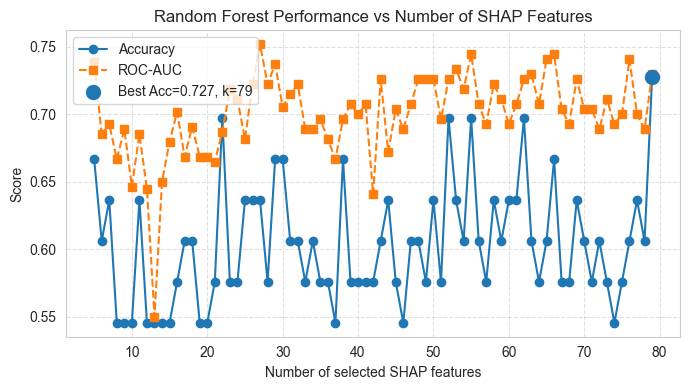


Best Accuracy = 0.727, ROC-AUC = 0.730, k = 79


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = shap_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")


Tento kód postupne prechádza rôzne počty najdôležitejších SHAP-príznakov (od 5 do 79) a pre každý takýto výber spúšťa RandomizedSearchCV, ktorý hľadá najlepšiu konfiguráciu hyperparametrov pre Random Forest. Vďaka tomu sa zároveň optimalizuje aj samotná veľkosť príznakového priestoru – teda zisťuje sa, koľko príznakov modelu skutočne pomáha. Analýza ukazuje, že najvyššia presnosť sa dosiahla pri 79 SHAP príznakoch, kde model dosiahol Accuracy = 0.727 a ROC-AUC = 0.730, čo znamená, že väčší počet SHAP príznakov zachytáva viac informácie bez pretrénovania. Záverečný graf vizuálne ukazuje trend metrík pri narastajúcom počte príznakov a pomáha vybrať optimálne množstvo pre finálny model.